In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve_fft
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

In [2]:
dpath = Path.cwd().parent / "data"
pvpath2 = dpath / "pv-common"

## Look at 1D spectra

We can use the bg-subtracted files that we have just saved. Plot the Ha and oiii on the same graph. Show a series of spatial ranges:

In [3]:
file_list = sorted(pvpath2.glob("*-pv-coadd-bgsub.fits"))

linehdus = {
    filepath.stem.split("-")[0]: fits.open(filepath)[0]
    for filepath in file_list
}


positions = (
    ("N knot", [20.0, 30.0]),
    ("N outer", [9.0, 18.0]),
    ("N inner", [2.0, 6.0]),
    ("Core", [-1.5, 1.5]),
    ("S inner", [-6.0, -2.0]),    
    ("S outer", [-18.0, -9.0]),
    ("S knot", [-30.0, -20.0]),
)

nlines = len(file_list)
npos = len(positions)

In [4]:
linehdus

{'ha': <astropy.io.fits.hdu.image.PrimaryHDU at 0x16708ec50>,
 'heii': <astropy.io.fits.hdu.image.PrimaryHDU at 0x167099010>,
 'nii': <astropy.io.fits.hdu.image.PrimaryHDU at 0x16709b450>,
 'oiii': <astropy.io.fits.hdu.image.PrimaryHDU at 0x1670a58d0>}

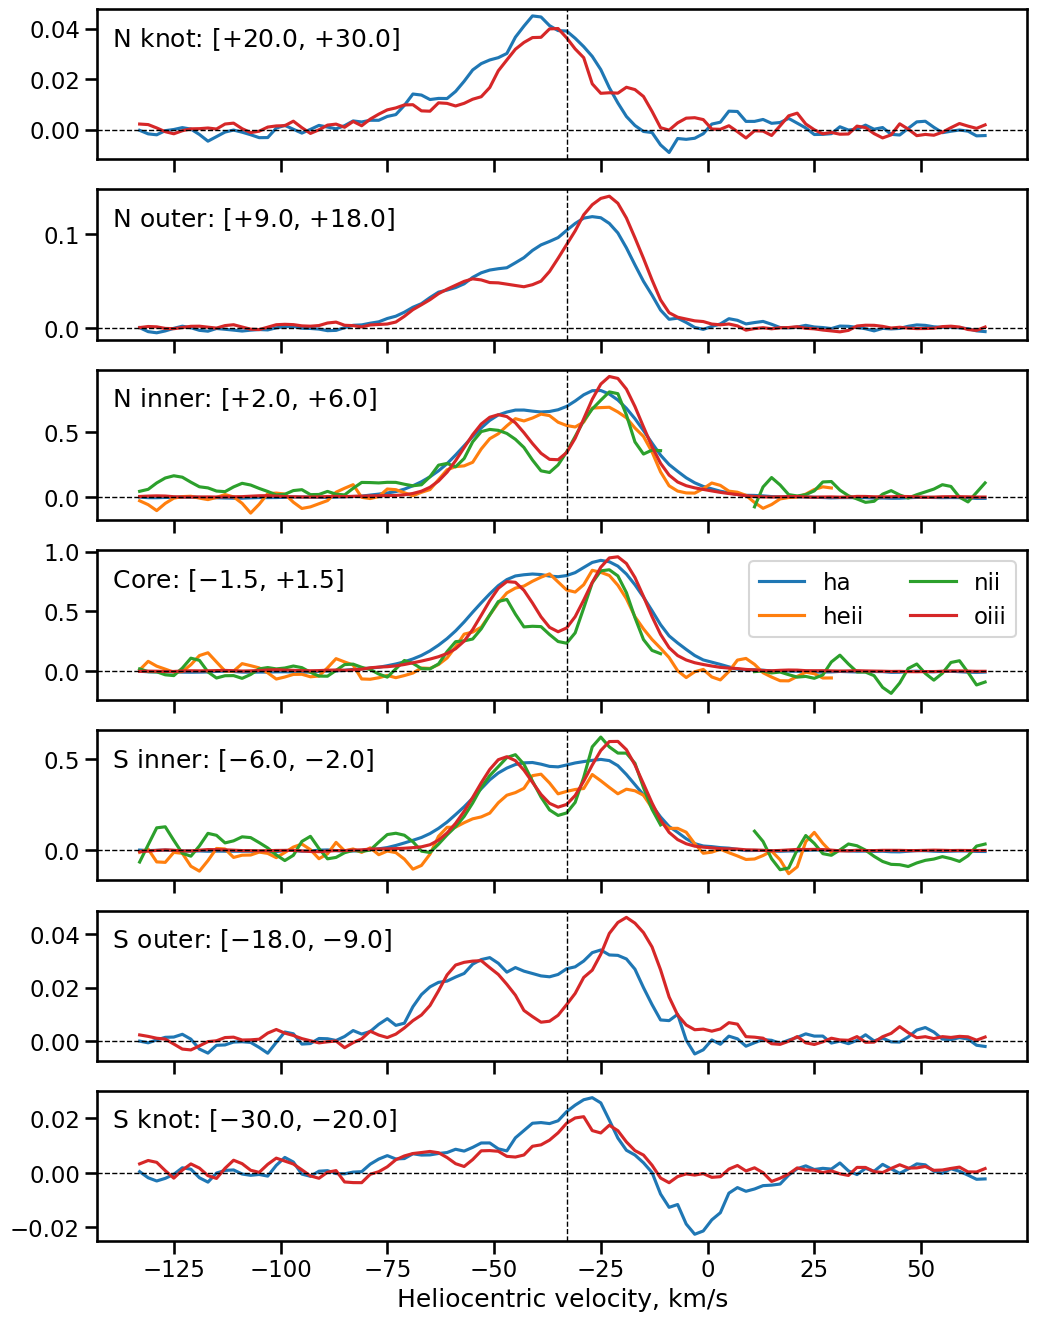

In [5]:
fig, axes = plt.subplots(
    npos, 
    1, 
    sharex=True,
    figsize=(12, 16),
)

vsys = -33
v1, v2 = vsys - 100, vsys + 100

skip = ["heii", "nii"]
for ax, [pos_label, [s1, s2]] in zip(axes, positions):
    for line_label, hdu in linehdus.items():
        w = WCS(hdu.header)
        ns, nv = hdu.data.shape
        xlims, ylims = w.world_to_pixel_values([v1, v2], [s1, s2])
        x1, x2 = [int(_) for _ in xlims]
        y1, y2 = [int(_) for _ in ylims]
        spec = hdu.data[y1:y2, x1:x2].mean(axis=0)
        vels, _ = w.pixel_to_world_values(np.arange(nv), [0]*nv)
        vels = vels[x1:x2]
        if line_label == "nii":
            spec[np.abs(vels) <= 10.0] = np.nan
        if line_label == "heii":
            spec[vels >= 30.0] = np.nan
        if line_label in skip and np.abs([s1, s2]).min() > 4:
            spec[:] = np.nan
        ax.plot(vels, spec, label=line_label)
    ax.axhline(0.0, linestyle="dashed", c="k", lw=1,)
    ax.axvline(vsys, linestyle="dashed", c="k", lw=1,)
    axtitle = f"  {pos_label}: [${s1:+.1f}$, ${s2:+.1f}$]"
    ax.set_title(axtitle, loc="left", y=0.7)
axes[3].legend(ncol=2)
axes[-1].set(
    xlabel="Heliocentric velocity, km/s",
)
figfile = "ou5-coadd-1dspec-all.pdf"
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))
...;

That version has all the lines for the brighter parts.  But, to be honest, they do not really add anything. 

In [6]:
from astropy.modeling import models, fitting

In [7]:
def mark_component(model, color, ax):
    v = model.mean.value
    a = model.amplitude.value
    ax.plot([v, v], [0.3 * a, 0.7 * a], lw=3, color=color, alpha=0.7)

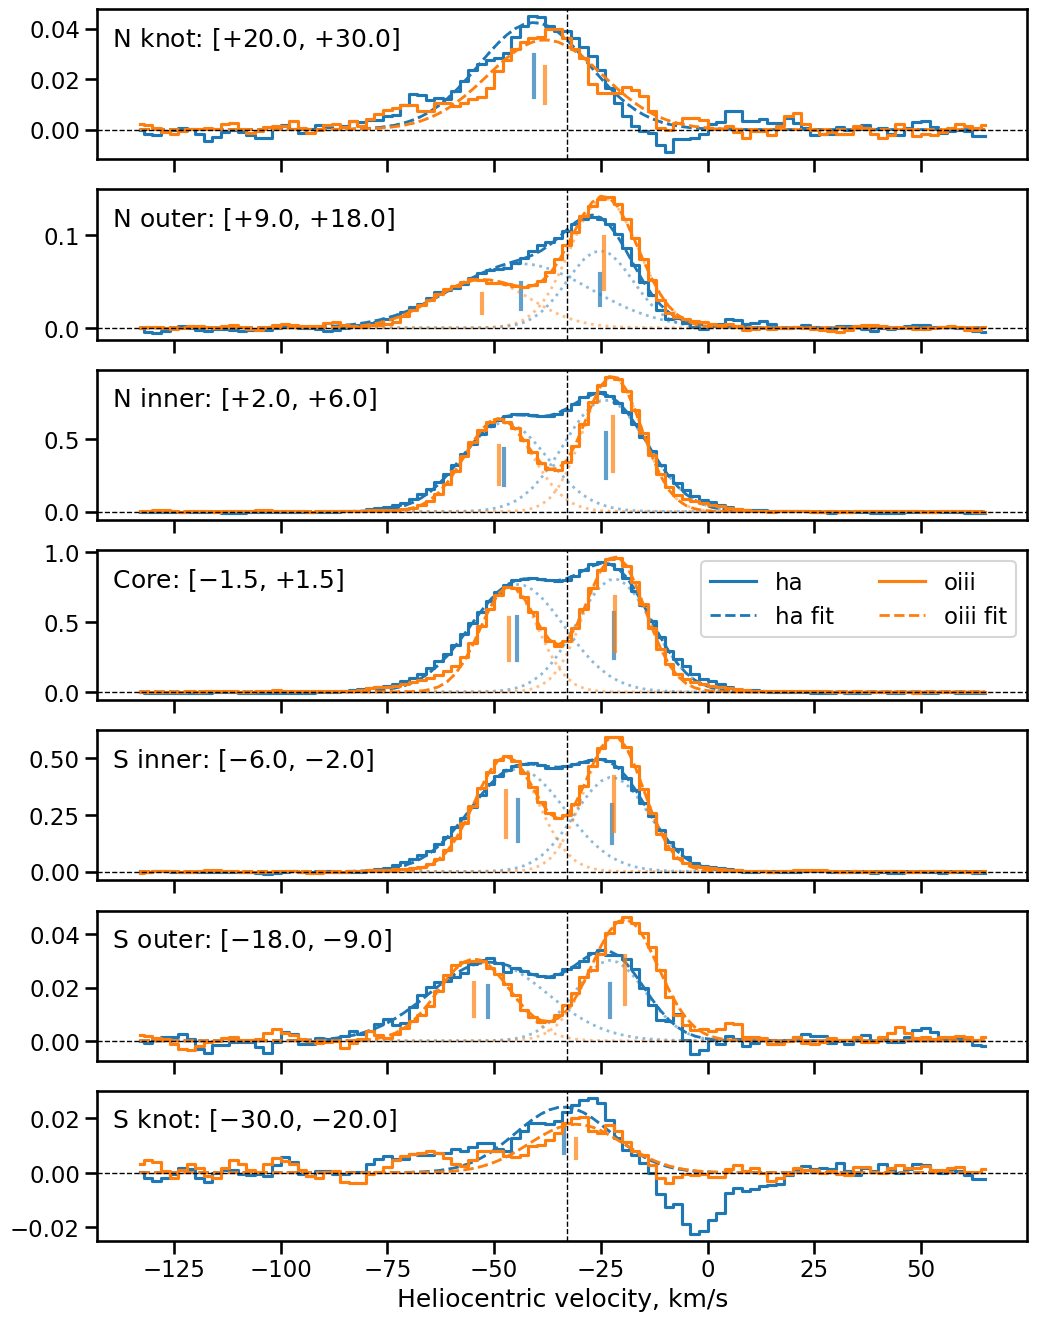

In [8]:
fig, axes = plt.subplots(
    npos, 
    1, 
    sharex=True,
    figsize=(12, 16),
)

vsys = -33
v1, v2 = vsys - 100, vsys + 100
fitter = fitting.LevMarLSQFitter()
keep = ["ha", "oiii"]
gfits = {}
for ax, [pos_label, [s1, s2]] in zip(axes, positions):
    for line_label, hdu in linehdus.items():
        if not line_label in keep:
            continue
        w = WCS(hdu.header)
        ns, nv = hdu.data.shape
        xlims, ylims = w.world_to_pixel_values([v1, v2], [s1, s2])
        x1, x2 = [int(_) for _ in xlims]
        y1, y2 = [int(_) for _ in ylims]
        spec = hdu.data[y1:y2, x1:x2].mean(axis=0)
        vels, _ = w.pixel_to_world_values(np.arange(nv), [0]*nv)
        vels = vels[x1:x2]
        dataline, = ax.plot(vels, spec, label=line_label, ds="steps-mid")
        c = dataline.get_color()
        
        # Fit two Gaussians
        mask1 = vels < vsys
        mask2 = ~mask1
        sm1 = spec[mask1].max()
        vm1 = vels[spec[mask1].argmax()]
        sm2 = spec[mask2].max()
        vm2 = vels[spec[mask2].argmax() + mask1.sum()]
        g1 = models.Gaussian1D(amplitude=sm1, mean=vm1, stddev=10.0)
        g2 = models.Gaussian1D(amplitude=sm2, mean=vm2, stddev=10.0)
        if "knot" in pos_label:
            init_model = g1
            fac = -0.5
        elif "outer" in pos_label:
            init_model = g1 + g2
            fac = 0.02           
        else:
            init_model = g1 + g2
            fac = 0.3
        fitmask = spec > fac * spec.max()
        fitted_model = fitter(init_model, vels[fitmask], spec[fitmask])
        gfits[(line_label, pos_label)] = fitted_model
        ax.plot(
            vels, 
            fitted_model(vels), 
            linestyle="dashed", 
            lw=2, 
            c=c,
            label=f"{line_label} fit",
        )
        if "knot" in pos_label:
            # special case of 1 component, therefore not compound model
            fitted_model = [fitted_model]
        for component in fitted_model:
            mark_component(component, c, ax)
            ax.plot(
                vels, 
                component(vels), 
                linestyle="dotted", 
                lw=2, 
                c=c,
                alpha=0.5,
            )


    ax.axhline(0.0, linestyle="dashed", c="k", lw=1,)
    ax.axvline(vsys, linestyle="dashed", c="k", lw=1,)
    axtitle = f"  {pos_label}: [${s1:+.1f}$, ${s2:+.1f}$]"
    ax.set_title(axtitle, loc="left", y=0.7)
axes[3].legend(ncol=2)
axes[-1].set(
    xlabel="Heliocentric velocity, km/s",
)
figfile = "ou5-coadd-1dspec-ha-oiii.pdf"
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))
...;

Now zoom the y axis, to look at the wings, but just for the inner regions:

In [9]:
cpos = {
    k: v for k, v in positions
    if np.abs(v).min() < 4
}
cpos

{'N inner': [2.0, 6.0], 'Core': [-1.5, 1.5], 'S inner': [-6.0, -2.0]}

In [10]:
def mark_component_low(model, color, ax):
    v = model.mean.value
    a = model.amplitude.value
    ax.plot([v, v], [0.03, 0.07], lw=3, color=color, alpha=0.7)

In [11]:
from astropy.convolution import convolve_models

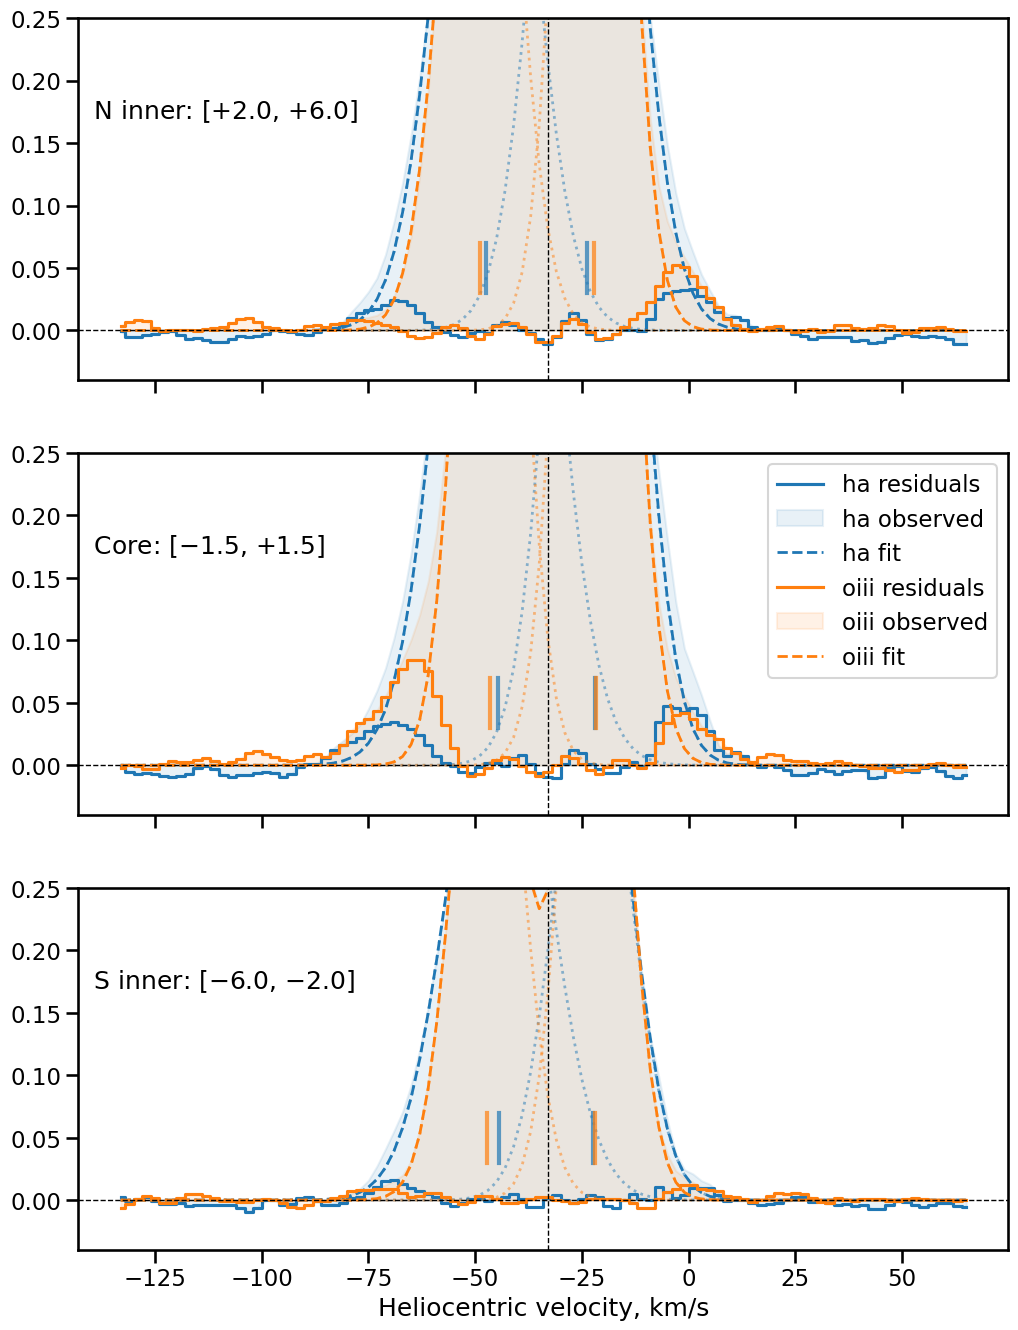

In [12]:
fig, axes = plt.subplots(
    len(cpos), 
    1, 
    sharex=True,
    figsize=(12, 16),
)

vsys = -33
v1, v2 = vsys - 100, vsys + 100
fitter = fitting.LevMarLSQFitter()
keep = ["ha", "oiii"]
gfits2 = {}
for ax, [pos_label, [s1, s2]] in zip(axes, cpos.items()):
    for line_label, hdu in linehdus.items():
        if not line_label in keep:
            continue
        w = WCS(hdu.header)
        ns, nv = hdu.data.shape
        xlims, ylims = w.world_to_pixel_values([v1, v2], [s1, s2])
        x1, x2 = [int(_) for _ in xlims]
        y1, y2 = [int(_) for _ in ylims]
        spec = hdu.data[y1:y2, x1:x2].mean(axis=0)
        vels, _ = w.pixel_to_world_values(np.arange(nv), [0]*nv)
        vels = vels[x1:x2]
        # Fit two Gaussians
        mask1 = vels < vsys
        mask2 = ~mask1
        sm1 = spec[mask1].max()
        vm1 = vels[spec[mask1].argmax()]
        sm2 = spec[mask2].max()
        vm2 = vels[spec[mask2].argmax() + mask1.sum()]
        g1 = models.Gaussian1D(amplitude=sm1, mean=vm1, stddev=10.0)
        g2 = models.Gaussian1D(amplitude=sm2, mean=vm2, stddev=10.0)
        g1b = models.Gaussian1D(amplitude=0.1 * sm1, mean=vm1, stddev=3.0)
        g2b = models.Gaussian1D(amplitude=0.1 * sm2, mean=vm2, stddev=3.0)

        init_model = g1 + g2 #+ g1b + g2b
        fitmask = spec > 0.3 * spec.max()
        fitted_model = fitter(init_model, vels[fitmask], spec[fitmask])
        #fitted_model = fitter(init_model, vels, spec)
        gfits2[(line_label, pos_label)] = fitted_model



        dataline, = ax.plot(
            vels, 
            spec - fitted_model(vels), 
            label=f"{line_label} residuals",
            ds="steps-mid",

        )
        c = dataline.get_color()
        ax.fill_between(vels, 0.0, spec, color=c, alpha=0.1, label=f"{line_label} observed")
        ax.plot(
            vels, 
            fitted_model(vels), 
            linestyle="dashed", 
            lw=2, 
            c=c,
            label=f"{line_label} fit",
        )
        for component in fitted_model[:2]:
            mark_component_low(component, c, ax)
        for component in fitted_model:
            ax.plot(
                vels, 
                component(vels), 
                linestyle="dotted", 
                lw=2, 
                c=c,
                alpha=0.5,
            )

           

    ax.axhline(0.0, linestyle="dashed", c="k", lw=1,)
    ax.axvline(vsys, linestyle="dashed", c="k", lw=1,)
    axtitle = f"  {pos_label}: [${s1:+.1f}$, ${s2:+.1f}$]"
    ax.set_title(axtitle, loc="left", y=0.7)
    ax.set(ylim=[-0.04, 0.25])
axes[1].legend(ncol=1)
axes[-1].set(
    xlabel="Heliocentric velocity, km/s",
)
figfile = "ou5-coadd-1dspec-wings.pdf"
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))
...;

In [13]:
import pandas as pd

In [14]:
m = gfits[("oiii", "Core")]
dict(zip(m.param_names, m.parameters))

{'amplitude_0': 0.751513097696343,
 'mean_0': -46.439625160343994,
 'stddev_0': 6.724643909915989,
 'amplitude_1': 0.966345948384001,
 'mean_1': -21.641922531441928,
 'stddev_1': 7.053840732372078}

In [15]:
pd.set_option('display.precision', 2)
df = pd.DataFrame(
    {k: dict(zip(m.param_names, m.parameters)) for k, m in gfits.items()}
).T
df.style.format(na_rep='—')

,,amplitude,mean,stddev,amplitude_0,mean_0,stddev_0,amplitude_1,mean_1,stddev_1
ha,N knot,0.042389,-40.619195,12.896915,—,—,—,—,—,—
oiii,N knot,0.035517,-37.990320,13.446481,—,—,—,—,—,—
ha,N outer,—,—,—,0.068855,-43.667293,16.222197,0.083037,-25.163743,7.735170
oiii,N outer,—,—,—,0.051693,-52.842413,11.288228,0.139760,-24.195254,7.981544
ha,N inner,—,—,—,0.614223,-47.561573,10.043531,0.772022,-23.856806,9.740985
oiii,N inner,—,—,—,0.643214,-48.938716,7.852685,0.937225,-22.203217,6.856336
ha,Core,—,—,—,0.767540,-44.573770,11.078650,0.804535,-21.830975,8.860060
oiii,Core,—,—,—,0.751513,-46.439625,6.724644,0.966346,-21.641923,7.053841
ha,S inner,—,—,—,0.453110,-44.496837,11.087169,0.416487,-22.415604,8.714986
oiii,S inner,—,—,—,0.506401,-47.136464,7.446451,0.596876,-21.893253,6.914524


## Compare with 2D spectra

Repeat from previous notebook, but add positions

In [16]:
positions

(('N knot', [20.0, 30.0]),
 ('N outer', [9.0, 18.0]),
 ('N inner', [2.0, 6.0]),
 ('Core', [-1.5, 1.5]),
 ('S inner', [-6.0, -2.0]),
 ('S outer', [-18.0, -9.0]),
 ('S knot', [-30.0, -20.0]))

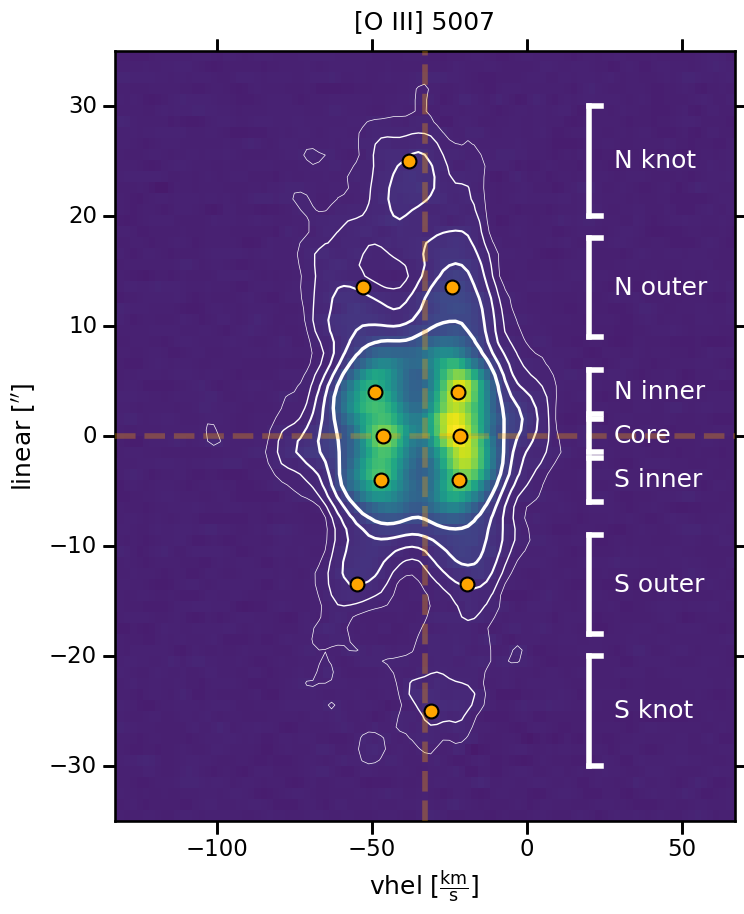

In [17]:
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=w))

vsys = -33
v1, v2 = vsys - 100, vsys + 100
s1, s2 = -35, 35

kernel = Gaussian2DKernel(x_stddev=1.0)
hdu = linehdus["oiii"]
w = WCS(hdu.header)
xlims, ylims = w.world_to_pixel_values([v1, v2], [s1, s2])
y1, y2 = [int(_) for _ in ylims]
x1, x2 = [int(_) for _ in xlims]
im = hdu.data
ax.imshow(im, vmin=-0.1, vmax=1.0, aspect="auto")
ims = convolve_fft(im, kernel)
ax.contour(
    ims, 
    levels=[0.01, 0.02, 0.04, 0.08, 0.16], 
    colors="w",
    linewidths=[0.5, 1.0, 1.5, 2.0, 2.5],
)
x0, y0 = w.world_to_pixel_values(vsys, 0.0)
ax.axhline(y0, color="orange", ls="dashed", lw=4, alpha=0.3)
ax.axvline(x0, color="orange", ls="dashed", lw=4, alpha=0.3)


# Add markers for the extracted regions
xp = 20.0
trw = ax.get_transform("world")
for plabel, ypp in positions:
    ax.plot([xp, xp], ypp, c="w", lw=4, transform=trw)
    for yp in ypp:
        ax.plot([xp, xp + 4], [yp, yp], c="w", lw=4, transform=trw)
    ax.text(xp + 8, np.mean(ypp), plabel, color="w", ha="left", va="center", transform=trw)

    
# Add markers for the Gaussian components
for plabel, ypp in positions:
    model = gfits[("oiii", plabel)]
    vmeans = [
        param 
        for name, param in zip(model.param_names, model.parameters)
        if name.startswith("mean")
    ]
    for vmean in vmeans:
        ax.scatter(
            vmean, 
            np.mean(ypp), 
            marker="o", 
            s=100, 
            c='orange',
            ec="k",
            alpha=1.0, 
            transform=trw,
            zorder=100,
        )
ax.set(xlim=xlims, ylim=ylims)
ax.set_title("[O III] 5007", pad=16)
figfile = "ou5-coadd-2dspec-oiii.pdf"
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))
...;

In [18]:
df = df.assign(dv=df.mean_1 - df.mean_0)

In [19]:
df.style.format(na_rep='—')

,,amplitude,mean,stddev,amplitude_0,mean_0,stddev_0,amplitude_1,mean_1,stddev_1,dv
ha,N knot,0.042389,-40.619195,12.896915,—,—,—,—,—,—,—
oiii,N knot,0.035517,-37.990320,13.446481,—,—,—,—,—,—,—
ha,N outer,—,—,—,0.068855,-43.667293,16.222197,0.083037,-25.163743,7.735170,18.503550
oiii,N outer,—,—,—,0.051693,-52.842413,11.288228,0.139760,-24.195254,7.981544,28.647159
ha,N inner,—,—,—,0.614223,-47.561573,10.043531,0.772022,-23.856806,9.740985,23.704767
oiii,N inner,—,—,—,0.643214,-48.938716,7.852685,0.937225,-22.203217,6.856336,26.735499
ha,Core,—,—,—,0.767540,-44.573770,11.078650,0.804535,-21.830975,8.860060,22.742795
oiii,Core,—,—,—,0.751513,-46.439625,6.724644,0.966346,-21.641923,7.053841,24.797703
ha,S inner,—,—,—,0.453110,-44.496837,11.087169,0.416487,-22.415604,8.714986,22.081232
oiii,S inner,—,—,—,0.506401,-47.136464,7.446451,0.596876,-21.893253,6.914524,25.243211


### Compare the line widths to estimate the temperature

In [20]:
df.xs("oiii")[['stddev_0', 'stddev_1']]

,stddev_0,stddev_1
N knot,NaN,NaN
N outer,11.29,7.98
N inner,7.85,6.86
Core,6.72,7.05
S inner,7.45,6.91
S outer,8.49,7.84
S knot,NaN,NaN


In [21]:
df.xs("ha")[['stddev_0', 'stddev_1']]

,stddev_0,stddev_1
N knot,NaN,NaN
N outer,16.22,7.74
N inner,10.04,9.74
Core,11.08,8.86
S inner,11.09,8.71
S outer,13.75,8.28
S knot,NaN,NaN


## Try fitting Gaussians to all the rows

Use bins of size 1 arcsec

In [22]:
fine_pix = 1.0
fine_positions = np.arange(-28, 29) * fine_pix
fine_positions

array([-28., -27., -26., -25., -24., -23., -22., -21., -20., -19., -18.,
       -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,
        -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,
         5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
        27.,  28.])

In [23]:
vsys = -33
v1, v2 = vsys - 100, vsys + 100
fitter = fitting.LevMarLSQFitter()
finefits = {}
finesingles = {}
fineprofiles = {}
hdu = linehdus["oiii"]
w = WCS(hdu.header)
ns, nv = hdu.data.shape

for finepos in fine_positions:
    s1, s2 = finepos - 0.5 * fine_pix, finepos + 0.5 * fine_pix 
    xlims, ylims = w.world_to_pixel_values([v1, v2], [s1, s2])
    x1, x2 = [int(_) for _ in xlims]
    y1, y2 = [int(_) for _ in ylims]
    spec = hdu.data[y1:y2+1, x1:x2+1].mean(axis=0)
    vels, _ = w.pixel_to_world_values(np.arange(nv), [0]*nv)
    vels = vels[x1:x2+1]
    sm = spec.max()
    g1 = models.Gaussian1D(amplitude=sm, mean=-50, stddev=10.0)
    g1.stddev.bounds = (5.0, 10.0)
    g2 = models.Gaussian1D(amplitude=sm, mean=-20, stddev=10.0)
    g2.stddev.bounds = (5.0, 10.0)
    init_model = g1 + g2
    # Tie together the component widths
    init_model.stddev_1.tied = lambda model: model.stddev_0
    fitted_model = fitter(init_model, vels, spec)
    gs = models.Gaussian1D(amplitude=sm, mean=vsys, stddev=10.0)
    fitted_single = fitter(gs, vels, spec)
    finefits[finepos] = fitted_model
    finesingles[finepos] = fitted_single
    fineprofiles[finepos] = {
        "v": vels,
        "spec": spec,
        "model": fitted_model(vels),
        "g1": fitted_model[0](vels),
        "g2": fitted_model[1](vels),
        "gs": fitted_single(vels),
    }
...;

In [24]:
fdf = pd.DataFrame(
    {k: dict(zip(m.param_names, m.parameters)) for k, m in finefits.items()}
).T
fdf.style.format(na_rep='—')

,amplitude_0,mean_0,stddev_0,amplitude_1,mean_1,stddev_1
-28.000000,0.017361,-49.698284,5.000000,0.015832,-31.667525,5.000000
-27.000000,0.009784,-47.880494,7.873136,0.017418,-27.333597,7.873136
-26.000000,0.006801,-60.377753,7.742873,0.021988,-29.376385,7.742873
-25.000000,0.000946,-36.396199,7.264598,0.031623,-26.880727,7.264598
-24.000000,0.008631,-65.052048,10.000000,0.033874,-27.080815,10.000000
-23.000000,0.007855,-65.523045,10.000000,0.030239,-29.465611,10.000000
-22.000000,0.022938,-31.597250,5.000000,0.013269,-19.065358,5.000000
-21.000000,0.011775,-39.466502,10.000000,0.014168,-16.560443,10.000000
-20.000000,0.014134,-48.236223,10.000000,0.015597,-17.504131,10.000000
-19.000000,0.012260,-60.880403,10.000000,0.017595,-24.268961,10.000000


In [25]:
fdfs = pd.DataFrame(
    {k: dict(zip(m.param_names, m.parameters)) for k, m in finesingles.items()}
).T
fdfs.style.format(na_rep='—')

,amplitude,mean,stddev
-28.000000,0.012629,-39.981363,13.326578
-27.000000,0.016634,-33.349319,12.323125
-26.000000,0.021065,-30.045324,9.301176
-25.000000,0.032003,-27.064653,7.344798
-24.000000,0.036008,-27.236910,9.020548
-23.000000,0.030293,-29.824403,10.156661
-22.000000,0.020980,-28.821911,11.665002
-21.000000,0.014898,-28.777042,20.303016
-20.000000,0.014863,-33.785500,23.918628
-19.000000,0.012511,-32.825978,26.364620


In [26]:
fdf = fdf.join(fdfs)

Calculate weighted mean of the velocities

In [27]:
fdf = fdf.assign(
    wmean = lambda x: (
        x.mean_0 * x.stddev_0 * x.amplitude_0
        + x.mean_1 * x.stddev_1 * x.amplitude_1
    ) / (x.stddev_0 * x.amplitude_0 + x.stddev_1 * x.amplitude_1),
    ratio_1_0 = lambda x: x.amplitude_1 / x.amplitude_0,
)

<Axes: >

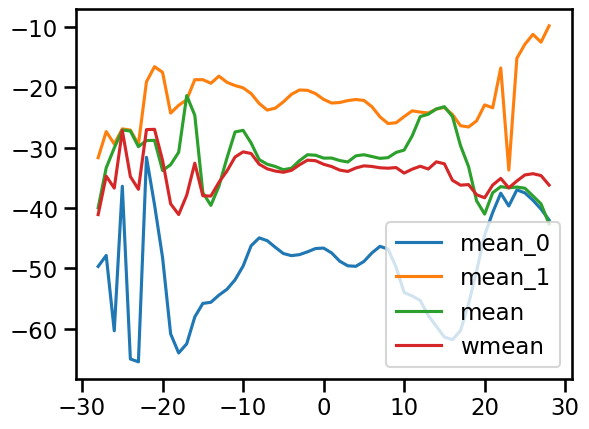

In [28]:
fdf[["mean_0", "mean_1", "mean", "wmean"]].plot()

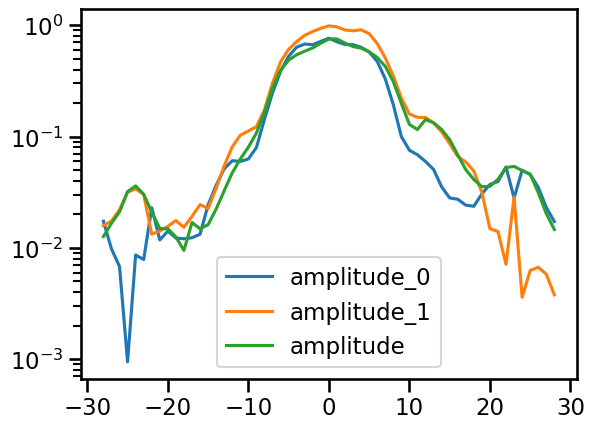

In [29]:
fdf[["amplitude_0", "amplitude_1", "amplitude"]].plot().set_yscale("log")

(0.0, 25.0)

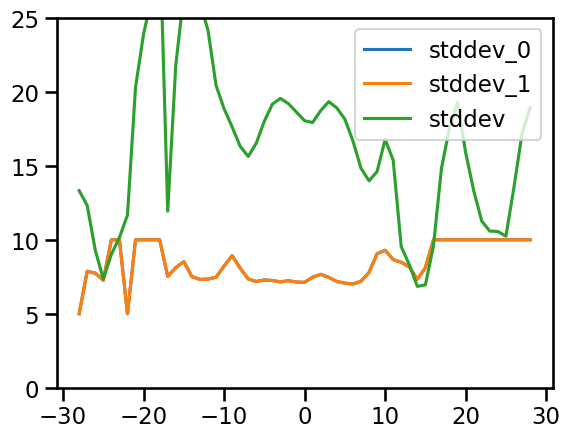

In [30]:
fdf[["stddev_0", "stddev_1", "stddev"]].plot().set_ylim(0.0, 25.0)

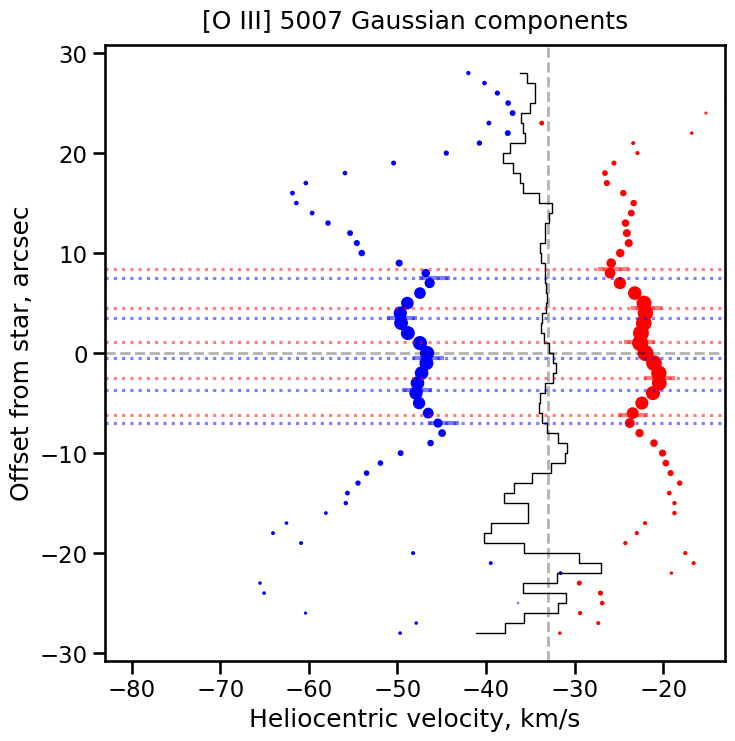

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
bluepaths = ax.scatter(
    fdf["mean_0"], 
    fdf.index,
    s=100 * fdf["amplitude_0"] * fdf["stddev_0"] / 7,    
    color="b",
)
redpaths = ax.scatter(
    fdf["mean_1"], 
    fdf.index,
    s=100 * fdf["amplitude_1"] * fdf["stddev_1"] / 7,   
    color="r",
)
bluecolor = bluepaths.get_facecolor()
redcolor = redpaths.get_facecolor()
# ax.scatter(
#     fdf["mean"], 
#     fdf.index,
#     s=100 * fdf["amplitude"] * fdf["stddev"] / 14,    
# )
ax.plot(
    fdf["wmean"], 
    fdf.index,
    color="k",
    ds="steps-mid",
    lw=1,
)
# Indicate the turning points in the velocity profiles
blue_tp = [
    (-45.8, 7.5),
    (-49.5, 3.5),
    (-46.5, -0.5),
    (-47.8, -3.7),
    (-44.8, -7.0),
]
red_tp = [
    (-25.6, 8.4),
    (-21.9, 4.5),
    (-22.7, 1.1),
    (-20.4, -2.5),
    (-23.4, -6.2),
]
dv = 1.5
alpha = 0.5
for v0, y0 in blue_tp:
    ax.axhline(y0, color=bluecolor, alpha=alpha, ls="dotted")
    ax.plot(
        [v0 - dv, v0 + dv], 
        [y0, y0], 
        color=bluecolor,
        lw=3,
        alpha=alpha,
        zorder=100,
    )
for v0, y0 in red_tp:
    ax.axhline(y0, color=redcolor, alpha=alpha, ls="dotted")
    ax.plot(
        [v0 - dv, v0 + dv], 
        [y0, y0], 
        color=redcolor,
        lw=3,
        alpha=alpha,
        zorder=100,
    )
# ax.plot(
#     0.5 * (fdf["mean_0"] + fdf["mean_1"]), 
#     fdf.index,
#     color="0.5",
# )
ax.axhline(0.0, color="k", ls="dashed", lw=2, alpha=0.3)
ax.axvline(vsys, color="k", ls="dashed", lw=2, alpha=0.3)
# ax.axvline(-36, color="k", ls="dotted", lw=2, alpha=0.3)
ax.set(
    xlabel="Heliocentric velocity, km/s",
    ylabel="Offset from star, arcsec",
    xlim=[-83.0, -13.0],
)
ax.set_title("[O III] 5007 Gaussian components", pad=12)
figfile = "ou5-coadd-pv-oiii-gaussians.pdf"
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))
...;

In [32]:
redblue_shifts = [_r[1] - _b[1] for _r, _b in zip(red_tp, blue_tp)]
redblue_shifts

[0.9000000000000004, 1.0, 1.6, 1.2000000000000002, 0.7999999999999998]

In [33]:
print(
f"""
Average redblue offset in turning points
is {np.mean(redblue_shifts):.1f} +/- {np.std(redblue_shifts):.1f} arcsec
""")


Average redblue offset in turning points
is 1.1 +/- 0.3 arcsec



From the profile along slit G we find that the cylindrical diameter of the nebula is $D = 8.7 +/- 0.1 arcsec. 

The offset should be $dz = D \cos i$, which gives $i = 83 \pm 2$

This compares very well with the Jones value of $82 \pm 1$

## Revisit the kinetic temperature measurement

The fact that Corradi et al 2015 are suggesting low temperature for the H emission means that it is vital to have an independent estimate of the temperature. 

I think that with the line width kinetic temperature we an get a good estimate

### Fine-scale fits for Ha

We just copy what we did for oiii above.  We reuse all these variables since the oiii results got saved in a dataframe `fdf`

We had to change the allowed bounds on the widths

In [34]:
vsys = -33
v1, v2 = vsys - 100, vsys + 100
fitter = fitting.LevMarLSQFitter()
hfinefits = {}
hfinesingles = {}
hfineprofiles = {}
hdu = linehdus["ha"]
w = WCS(hdu.header)
ns, nv = hdu.data.shape

for finepos in fine_positions:
    s1, s2 = finepos - 0.5 * fine_pix, finepos + 0.5 * fine_pix 
    xlims, ylims = w.world_to_pixel_values([v1, v2], [s1, s2])
    x1, x2 = [int(_) for _ in xlims]
    y1, y2 = [int(_) for _ in ylims]
    spec = hdu.data[y1:y2+1, x1:x2+1].mean(axis=0)
    vels, _ = w.pixel_to_world_values(np.arange(nv), [0]*nv)
    vels = vels[x1:x2+1]
    sm = spec.max()
    g1 = models.Gaussian1D(amplitude=sm, mean=-50, stddev=10.0)
    g1.stddev.bounds = (7.0, 15.0)
    g2 = models.Gaussian1D(amplitude=sm, mean=-20, stddev=10.0)
    g2.stddev.bounds = (7.0, 15.0)
    init_model = g1 + g2
    # Tie together the component widths
    init_model.stddev_1.tied = lambda model: model.stddev_0
    fitted_model = fitter(init_model, vels, spec)
    gs = models.Gaussian1D(amplitude=sm, mean=vsys, stddev=10.0)
    fitted_single = fitter(gs, vels, spec)
    hfinefits[finepos] = fitted_model
    hfinesingles[finepos] = fitted_single
    hfineprofiles[finepos] = {
        "v": vels,
        "spec": spec,
        "model": fitted_model(vels),
        "g1": fitted_model[0](vels),
        "g2": fitted_model[1](vels),
        "gs": fitted_single(vels),
    }
...;

In [35]:
fdf_h = pd.DataFrame(
    {k: dict(zip(m.param_names, m.parameters)) for k, m in hfinefits.items()}
).T
fdf_h.style.format(na_rep='—')

,amplitude_0,mean_0,stddev_0,amplitude_1,mean_1,stddev_1
-28.000000,0.012641,-52.670241,8.695609,0.019061,-32.852609,8.695609
-27.000000,0.009572,-61.034161,8.964360,0.024049,-32.948101,8.964360
-26.000000,0.006198,-47.331059,9.843328,0.024343,-33.165043,9.843328
-25.000000,0.009658,-61.258650,9.132403,0.036304,-30.173726,9.132403
-24.000000,0.007943,-51.986459,12.142779,0.029812,-29.147329,12.142779
-23.000000,0.013042,-65.478947,10.136494,0.035623,-29.908475,10.136494
-22.000000,0.007260,-51.985066,13.148574,0.022833,-28.917592,13.148574
-21.000000,0.005407,-71.315952,15.000000,0.020920,-34.864372,15.000000
-20.000000,0.015816,-36.597095,15.000000,0.007945,-49.303623,15.000000
-19.000000,0.017476,-40.804119,15.000000,0.005308,-50.171503,15.000000


In [36]:
fdfs_h = pd.DataFrame(
    {k: dict(zip(m.param_names, m.parameters)) for k, m in hfinesingles.items()}
).T
fdfs_h.style.format(na_rep='—')

,amplitude,mean,stddev
-28.000000,0.020772,-40.445288,12.426417
-27.000000,0.024385,-34.129945,9.381329
-26.000000,0.029230,-34.322213,9.278370
-25.000000,0.034975,-31.039487,9.670089
-24.000000,0.039955,-29.559438,8.961263
-23.000000,0.038250,-30.100768,9.292834
-22.000000,0.032343,-29.809510,9.424820
-21.000000,0.026196,-33.928054,11.115914
-20.000000,0.022591,-40.217379,15.075903
-19.000000,0.022384,-42.602724,14.863256


In [37]:
fdf_h = fdf_h.join(fdfs_h)
fdf_h = fdf_h.assign(
    wmean = lambda x: (
        x.mean_0 * x.stddev_0 * x.amplitude_0
        + x.mean_1 * x.stddev_1 * x.amplitude_1
    ) / (x.stddev_0 * x.amplitude_0 + x.stddev_1 * x.amplitude_1),
    ratio_1_0 = lambda x: x.amplitude_1 / x.amplitude_0,
)

#### Compare velocities

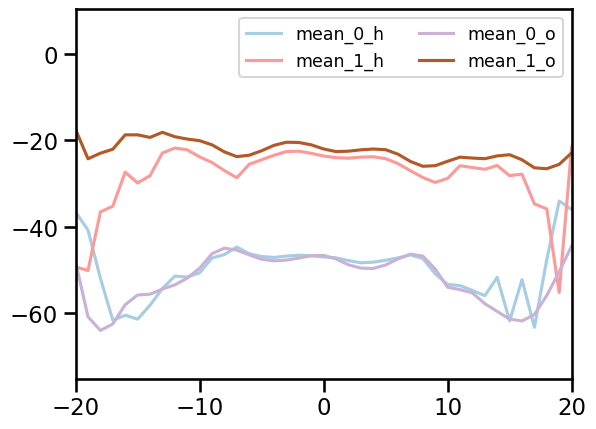

In [38]:
ax = fdf_h[["mean_0", "mean_1"]].join(
    fdf[["mean_0", "mean_1"]],
    lsuffix="_h", rsuffix="_o",
).plot(colormap="Paired")
ax.set_xlim(-20, 20)
ax.legend(ncol=2, fontsize="x-small")

#### Compare widths

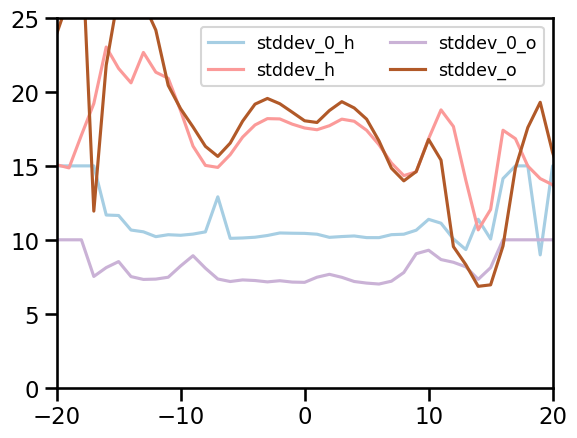

In [39]:
ax = fdf_h[["stddev_0", "stddev"]].join(
    fdf[["stddev_0", "stddev"]],
    lsuffix="_h", rsuffix="_o",
).plot(colormap="Paired")
ax.set_ylim(0.0, 25.0)
ax.set_xlim(-20, 20)

ax.legend(ncol=2, fontsize="x-small")

#### Compare intensities

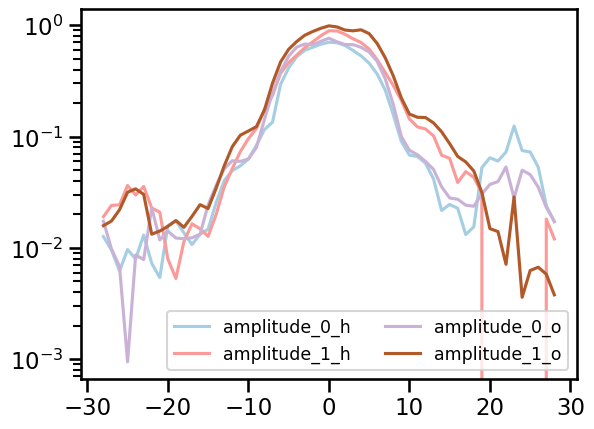

In [40]:
ax = fdf_h[["amplitude_0", "amplitude_1"]].join(
    fdf[["amplitude_0", "amplitude_1"]],
    lsuffix="_h", rsuffix="_o",
).plot(colormap="Paired")
ax.legend(ncol=2, fontsize="x-small")
ax.set_yscale("log")

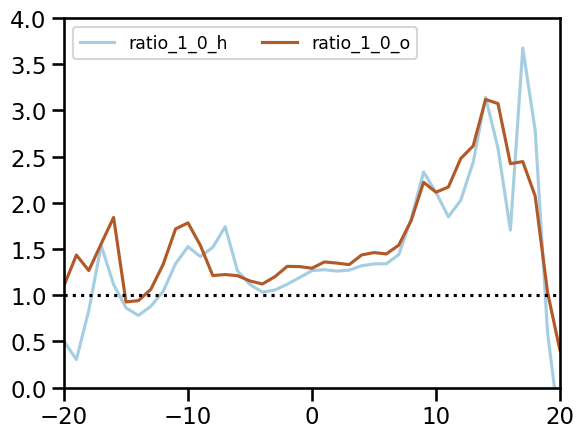

In [41]:
ax = fdf_h[["ratio_1_0"]].join(
    fdf[["ratio_1_0"]],
    lsuffix="_h", rsuffix="_o",
).plot(colormap="Paired")
ax.legend(ncol=2, fontsize="x-small")
ax.set_ylim(0.0, 4.0)
ax.set_xlim(-20, 20)
ax.axhline(1.0, color="k", ls="dotted")

#### Compare everything

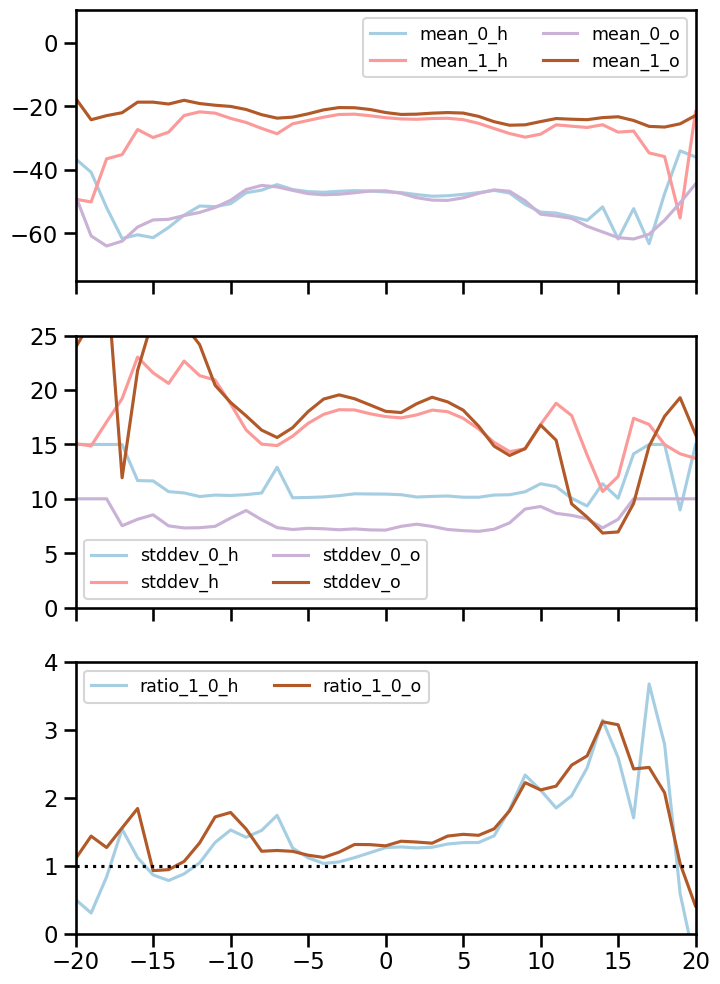

In [42]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 12))

ax = axes[0]
fdf_h[["mean_0", "mean_1"]].join(
    fdf[["mean_0", "mean_1"]],
    lsuffix="_h", rsuffix="_o",
).plot(ax = ax, colormap="Paired")
ax.set_xlim(-20, 20)
ax.legend(ncol=2, fontsize="x-small")

ax = axes[1]
fdf_h[["stddev_0", "stddev"]].join(
    fdf[["stddev_0", "stddev"]],
    lsuffix="_h", rsuffix="_o",
).plot(ax=ax, colormap="Paired")
ax.set_ylim(0.0, 25.0)
ax.set_xlim(-20, 20)
ax.legend(ncol=2, fontsize="x-small")

ax = axes[2]
ax = fdf_h[["ratio_1_0"]].join(
    fdf[["ratio_1_0"]],
    lsuffix="_h", rsuffix="_o",
).plot(ax=ax, colormap="Paired")
ax.legend(ncol=2, fontsize="x-small")
ax.set_ylim(0.0, 4.0)
ax.set_xlim(-20, 20)
ax.axhline(1.0, color="k", ls="dotted")

### Compare variances from fits

If we assume that the non-thermal broadening is the same for Ha and [O III], then the variances should be related as 
$$
\sigma^2(\mathrm{H\alpha}) = \sigma^2(\mathrm{[O III]}) + 77.34 T_4 + 10.233
$$
where the constant term is from the fine-structure broadening (see Garcia-Díaz & Henney 2008). Although there may also be a difference in the instrumental width.

In [43]:
w_h = 3e5 * 0.26 / 6563
w_o = 3e5 * 0.19 / 5007
w_h, w_o

(11.884808776474173, 11.384062312762133)

So the instrumental width in km/s is almost identical for the two lines. Hence we will not try to correct for it. 

In [44]:
w_o ** 2 / (8 * np.log(2))

23.37109606291676

In [45]:
vardf = fdf_h[["stddev_0", "stddev_1", "stddev"]].join(
    fdf[["stddev_0", "stddev_1", "stddev", "amplitude_1"]],
    lsuffix="_h", rsuffix="_o",
)

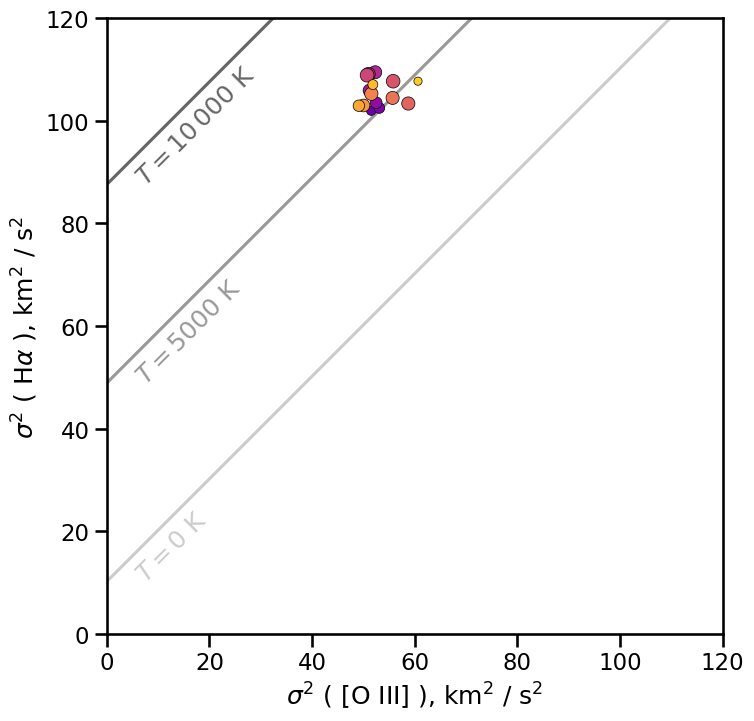

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
scale = np.where(
    vardf["amplitude_1"] > 0.3,
    vardf["amplitude_1"],
    np.nan,
)
ax.scatter(
    vardf["stddev_0_o"]**2,
    vardf["stddev_0_h"]**2,
    s=100 * scale,
    c=vardf.index,
    cmap="plasma",    
    vmin=-10, vmax=10,
    zorder=100,
    alpha=1.0,
    edgecolors="k",
    linewidths=0.5,
)
xx = np.array([0, 200])
ax.plot(xx, xx + 10.233, c="0.8")
ax.text(5, 5 - 5 + 10.233, r"$T = 0$ K", rotation=45, c="0.8")
ax.plot(xx, xx + 10.233 + 77.34 / 2, c="0.6")
ax.text(5, 5 - 5 + 10.233 + 77.34 / 2, r"$T = 5000$ K", rotation=45, c="0.6")
ax.plot(xx, xx + 10.233 + 77.34, c="0.4")
ax.text(5, 5 - 5 + 10.233 + 77.34, r"$T = 10\,000$ K", rotation=45, c="0.4")
ax.set_xlim(0, 120)
ax.set_ylim(0, 120)
# ax.set_yticks([0, 50, 100, 150])
ax.set_xticks(ax.get_yticks())
ax.set_aspect("equal")
ax.set_xlabel(r"$\sigma^2$ ( [O III] ), km$^2$ / s$^2$")
ax.set_ylabel(r"$\sigma^2$ ( H$\alpha$ ), km$^2$ / s$^2$")
figfile = "pn-ou5-gaussfit-temperature.pdf"
fig.savefig(figfile)
fig.savefig(figfile.replace(".pdf", ".jpg"))


In [47]:
dsigsq = vardf["stddev_0_h"]**2 - vardf["stddev_0_o"]**2
weights = scale
m = np.isfinite(scale)
mean_dsigsq = np.average(dsigsq[m], weights=weights[m])
std_dsigsq = np.sqrt(
    np.average((dsigsq[m] - mean_dsigsq)**2, weights=weights[m])
)
mean_dsigsq, std_dsigsq

(54.350329163295804, 10.22146743269051)

In [48]:
mean_T4 = (mean_dsigsq - 10.233) / 77.34
std_T4 = std_dsigsq / 77.34
mean_T4, std_T4

(0.5704335293935325, 0.1321627544956104)

So $T = 5700 \pm 1300$ K

### Non-parametric version

Directly compare the moments in a window about the line

## Look at the individual profile fits in more detail                                                                                                                        
We want to see whether it makes sense to fit two gaussians in the outer lobes

[(-95.0, 25.0)]

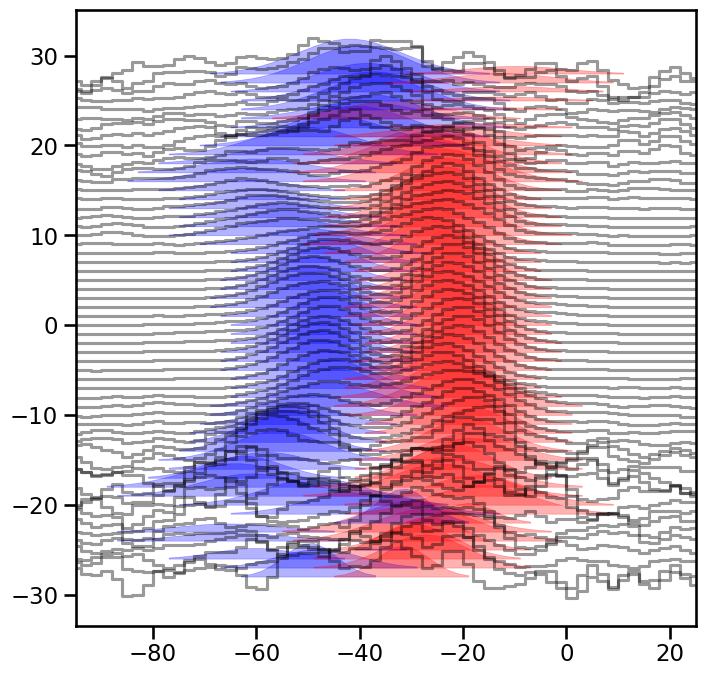

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))
for pos in fine_positions:
    data = fineprofiles[pos]
    v = data["v"]
    norm = np.max(data["spec"])
    g1 = np.where(data["g1"] > 0.02 * norm, data["g1"] , np.nan)
    g2 = np.where(data["g2"] > 0.02 * norm, data["g2"], np.nan)
    ax.fill_between(v, pos + 4 * g1 / norm, pos, color="b", lw=0.5, alpha=0.3)
    ax.fill_between(v, pos + 4 * g2 / norm, pos, color="r", lw=0.5, alpha=0.3)
    ax.plot(v, pos + 4 * data["spec"] / norm, color="k", alpha=0.4, drawstyle="steps-mid")
ax.set(
    xlim=[-95, 25],
)

Repeat but for northern outer lobe

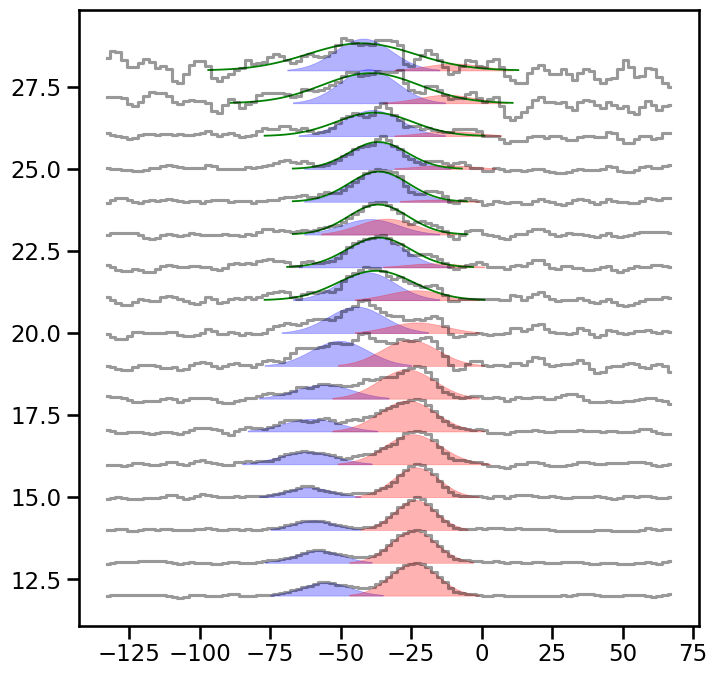

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))
for pos in fine_positions:
    if pos < 12.0:
        continue
    data = fineprofiles[pos]
    v = data["v"]
    norm = np.max(data["spec"])
    scale = 1.0
    g1 = np.where(data["g1"] > 0.02 * norm, data["g1"], np.nan)
    g2 = np.where(data["g2"] > 0.02 * norm, data["g2"], np.nan)
    ax.fill_between(v, pos + scale * g1 / norm, pos, color="b", lw=0.5, alpha=0.3)
    ax.fill_between(v, pos + scale * g2 / norm, pos, color="r", lw=0.5, alpha=0.3)
    if abs(pos) > 20.0:
        gs = np.where(data["gs"] > 0.01 * norm, data["gs"], np.nan)
        ax.plot(v, pos + scale * gs / norm, color="g", lw=1.3)
    ax.plot(v, pos + scale * data["spec"] / norm, color="k", alpha=0.4, drawstyle="steps-mid")

And for southern lobe

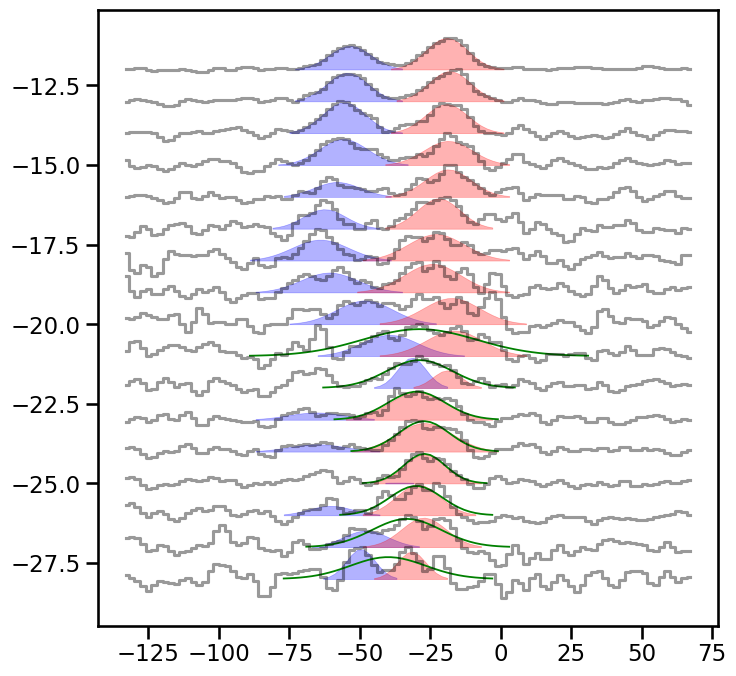

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))
for pos in fine_positions:
    if pos > -12.0:
        continue
    data = fineprofiles[pos]
    v = data["v"]
    norm = np.max(data["spec"])
    scale = 1.0
    g1 = np.where(data["g1"] > 0.02 * norm, data["g1"], np.nan)
    g2 = np.where(data["g2"] > 0.02 * norm, data["g2"], np.nan)
    ax.fill_between(v, pos + scale * g1 / norm, pos, color="b", lw=0.5, alpha=0.3)
    ax.fill_between(v, pos + scale * g2 / norm, pos, color="r", lw=0.5, alpha=0.3)
    if abs(pos) > 20.0:
        gs = np.where(data["gs"] > 0.01 * norm, data["gs"], np.nan)
        ax.plot(v, pos + scale * gs / norm, color="g", lw=1.3)
    ax.plot(v, pos + scale * data["spec"] / norm, color="k", alpha=0.4, drawstyle="steps-mid")

### Central region for [O III]

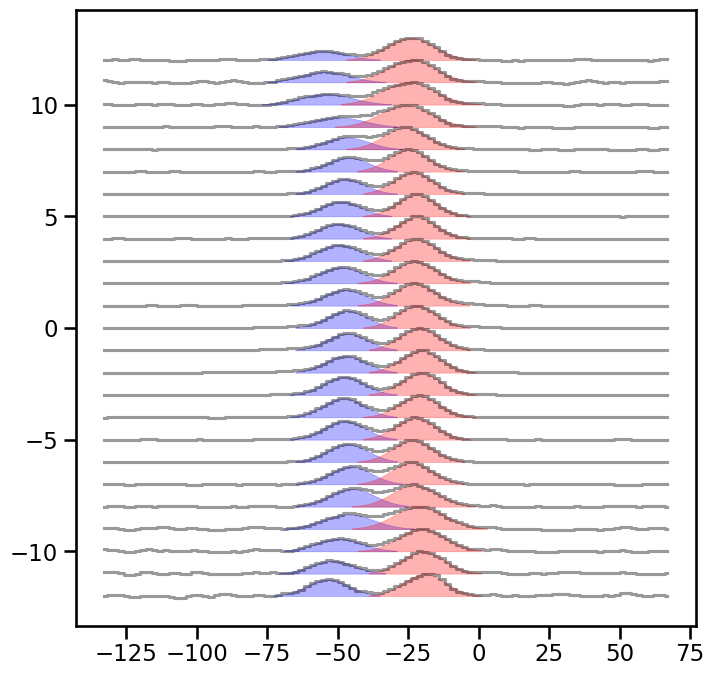

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
for pos in fine_positions:
    if abs(pos) > 12.0:
        continue
    data = fineprofiles[pos]
    v = data["v"]
    norm = np.max(data["spec"])
    scale = 1.0
    g1 = np.where(data["g1"] > 0.02 * norm, data["g1"], np.nan)
    g2 = np.where(data["g2"] > 0.02 * norm, data["g2"], np.nan)
    ax.fill_between(v, pos + scale * g1 / norm, pos, color="b", lw=0.5, alpha=0.3)
    ax.fill_between(v, pos + scale * g2 / norm, pos, color="r", lw=0.5, alpha=0.3)
    if abs(pos) > 20.0:
        gs = np.where(data["gs"] > 0.01 * norm, data["gs"], np.nan)
        ax.plot(v, pos + scale * gs / norm, color="g", lw=1.3)
    ax.plot(v, pos + scale * data["spec"] / norm, color="k", alpha=0.4, drawstyle="steps-mid")

### Central region for Ha

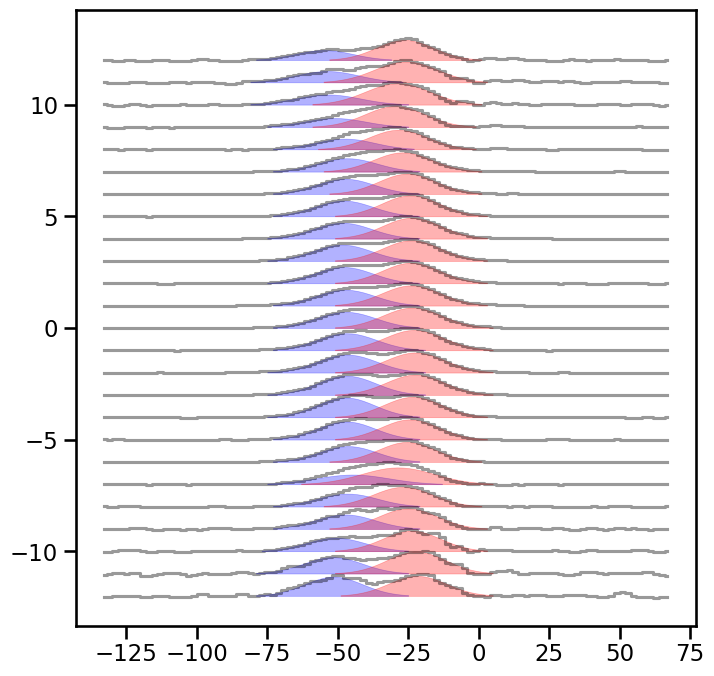

In [53]:
fig, ax = plt.subplots(figsize=(8, 8))
for pos in fine_positions:
    if abs(pos) > 12.0:
        continue
    data = hfineprofiles[pos]
    v = data["v"]
    norm = np.max(data["spec"])
    scale = 1.0
    g1 = np.where(data["g1"] > 0.02 * norm, data["g1"], np.nan)
    g2 = np.where(data["g2"] > 0.02 * norm, data["g2"], np.nan)
    ax.fill_between(v, pos + scale * g1 / norm, pos, color="b", lw=0.5, alpha=0.3)
    ax.fill_between(v, pos + scale * g2 / norm, pos, color="r", lw=0.5, alpha=0.3)
    if abs(pos) > 20.0:
        gs = np.where(data["gs"] > 0.01 * norm, data["gs"], np.nan)
        ax.plot(v, pos + scale * gs / norm, color="g", lw=1.3)
    ax.plot(v, pos + scale * data["spec"] / norm, color="k", alpha=0.4, drawstyle="steps-mid")

### Inner lobes for both

(-90.0, 10.0)

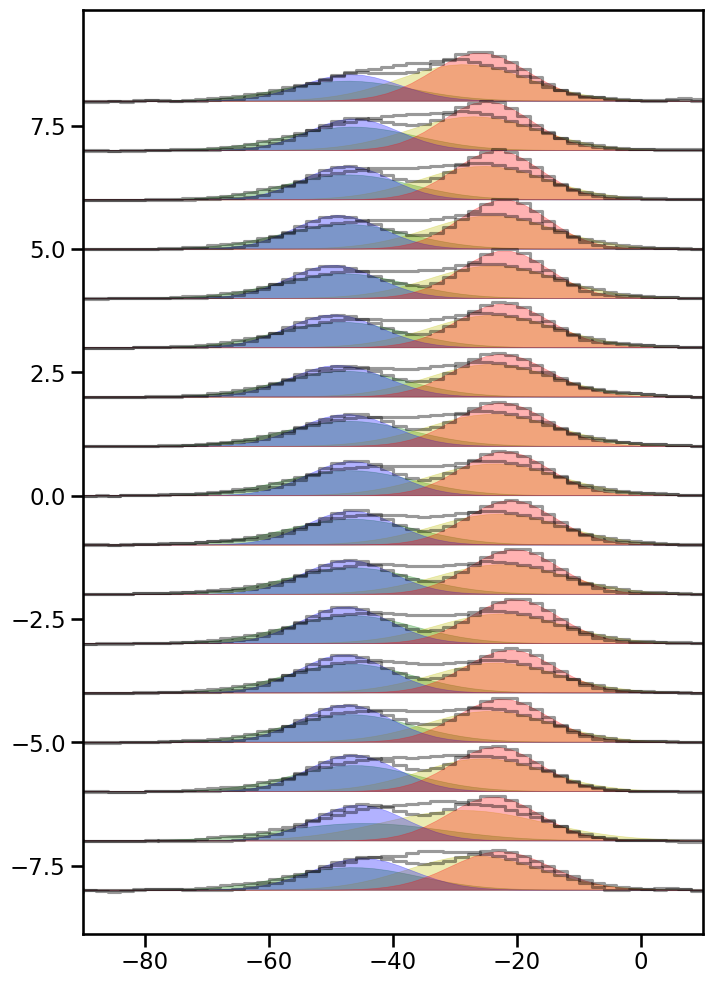

In [54]:
fig, ax = plt.subplots(figsize=(8, 12))
for pos in fine_positions:
    if abs(pos) > 8.0:
        continue
    for shift, data, bc, rc in (-0.25, hfineprofiles[pos], "g", "y"), (0.25, fineprofiles[pos], "b", "r"):
        v = data["v"]
        norm = np.sum(data["spec"])
        scale = 15
        g1 = data["g1"]
        g2 = data["g2"]
        ax.fill_between(v, pos + scale * g1 / norm, pos, color=bc, lw=0.5, alpha=0.3)
        ax.fill_between(v, pos + scale * g2 / norm, pos, color=rc, lw=0.5, alpha=0.3)
        ax.plot(v, pos + scale * data["spec"] / norm, color="k", alpha=0.4, drawstyle="steps-mid")
ax.set_xlim(-90, 10)